<a href="https://colab.research.google.com/github/yohei0408/kikagaku/blob/main/20241007_signate_cup_train_test_toCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ライブラリのimportを行います
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/train.csv')
df = df.drop(['id'], axis=1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3206 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3206 non-null   object 
 1   TypeofContact           3206 non-null   object 
 2   CityTier                3206 non-null   int64  
 3   DurationOfPitch         3206 non-null   object 
 4   Occupation              3206 non-null   object 
 5   Gender                  3206 non-null   object 
 6   NumberOfPersonVisiting  3206 non-null   float64
 7   NumberOfFollowups       3206 non-null   float64
 8   ProductPitched          3206 non-null   object 
 9   PreferredPropertyStar   3206 non-null   float64
 10  NumberOfTrips           3206 non-null   object 
 11  Passport                3206 non-null   int64  
 12  PitchSatisfactionScore  3206 non-null   int64  
 13  Designation             3206 non-null   object 
 14  MonthlyIncome           3206 non-null   objec

In [3]:
import re
# 変換関数の定義
def convert_age(age_str):
    # 漢数字をアラビア数字に変換
    kanji_numbers = {
        '一': 1, '二': 2, '三': 3, '四': 4, '五': 5,
        '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
        '百': 100, '千': 1000
    }

    # 漢数字の変換
    def kanji_to_num(kanji):
        num = 0
        temp = 0
        for char in kanji:
            if char in kanji_numbers:
                temp += kanji_numbers[char]
            else:
                num += temp
                temp = 0
        return num + temp

    # 年齢の文字列を変換
    age_str = re.sub(r'[歳才際]', '', age_str)  # 歳、才、際を削除
    age_str = re.sub(r'[\u3000-\u303F]', '', age_str)  # 全角数字を半角に
    age_str = re.sub(r'([0-9]+)', r'\1', age_str)  # 半角数字をそのまま
    age_str = re.sub(r'([０-９])', lambda x: str(int(x.group(0))), age_str)  # 全角数字を半角に変換

    # 大文字の「24」を変換
    if '代' in age_str:
        age_str = age_str.replace('代', '')

    # 漢数字の変換
    if re.search(r'[一二三四五六七八九十百千]', age_str):
        age_str = str(kanji_to_num(age_str))

    return int(age_str)

# Age列の変換を実行
df['Age'] = df['Age'].apply(convert_age)

df['Age'].describe()

,Age
count,3206.000000
mean,38.072052
std,10.724203
min,10.000000
25%,30.000000
50%,38.000000
75%,47.000000
max,61.000000


In [4]:
# 変換関数の定義
def convert_duration(duration_str):
    if '秒' in duration_str:
        # 秒の値をそのまま返す
        return int(duration_str.replace('秒', ''))
    elif '分' in duration_str:
        # 分の値を秒に変換
        minutes = int(duration_str.replace('分', ''))
        return minutes * 60
    else:
        return 0  # それ以外の場合は0を返す

# DurationOfPitch列の変換を実行
df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_duration)
df['DurationOfPitch'].describe()

,DurationOfPitch
count,3206.000000
mean,860.530256
std,418.097727
min,240.000000
25%,540.000000
50%,780.000000
75%,960.000000
max,2160.000000


In [5]:
# 変換関数の定義
def convert_gender(gender_str):
    # 全角英字を半角に変換
    gender_str = re.sub(r'[Ａ-Ｚａ-ｚ]', lambda x: chr(ord(x.group(0)) - 0xFEE0), gender_str)
    # スペースを削除
    gender_str = gender_str.replace(" ", "").replace("　", "")
    # 小文字に変換
    gender_str = gender_str.lower()
    # 変換
    if gender_str in ['female', 'femaie', 'femal', 'femle', 'femal', 'fem']:
        return 'female'
    elif gender_str in ['male', 'maie', 'mal', 'male']:
        return 'male'
    else:
        return gender_str  # 変換できない場合はそのまま返す


# Gender列の変換を実行
df['Gender'] = df['Gender'].apply(convert_gender)

In [7]:
# 変換関数の定義
def convert_product(product_str):
    # 小文字に変換
    product_str = product_str.lower()

    # 特定の文字列の置換
    product_str = re.sub(r'de[|×]?u[|×]?xe', 'deluxe', product_str)
    product_str = re.sub(r'super\s?deluxe', 'super deluxe', product_str)

    # 統一した文字列の定義
    if 'super deluxe' in product_str or 'super dεluxe' in product_str:
        return 'super deluxe'
    elif ('ꭰeluxe' in product_str or
          'de|u×e' in product_str or
          'delu×e' in product_str or
          'ᗞeluxe' in product_str or
          'ꭰeluxe' in product_str or
          '𝙳eluxe' in product_str or
          'dεluxε' in product_str or
          'deluxe' in product_str or

        'deluxe' in product_str):
        return 'deluxe'
    elif ('standard' in product_str or
          'stanᗞard' in product_str or
          'standar𝔡' in product_str or
          'staոdard' in product_str or
          'st𝖺ndard' in product_str or
          's𝘵andard' in product_str or
          'stand𝖺rd' in product_str or
          'տtandard' in product_str or
          'standarꭰ' in product_str or
          'ꓢtandard' in product_str or
          'ѕtandard' in product_str or
          'ꓢtandard' in product_str or
          'տtanda𝘳d' in product_str or
          'ѕtandard' in product_str or
          'տtandard' in product_str or
          'standa𝘳d' in product_str):
        return 'standard'
    elif ('basic' in product_str or
          'basiс' in product_str or
          'b𝖺sic' in product_str or
          'baꓢic' in product_str or
          'βasic' in product_str or
          'вasic' in product_str or
          'basi𝘤' in product_str or
          'basiϲ' in product_str or
          'baտic' in product_str or
          'βası𝘤' in product_str or
          'baｓic' in product_str or
          '𐊡asic' in product_str or
          'basιc' in product_str or
          'в𝖺sic' in product_str or
          '𐊡asi𝘤' in product_str or
          'βasıc' in product_str or
          'b𝖺si𝘤' in product_str or
          'вasic' in product_str or
          'βasiс' in product_str or
          'basıc' in product_str):
        return 'basic'
    elif 'king' in product_str or 'kıոg' in product_str or 'kiոg' in product_str:
        return 'king'
    else:
        print(f"Unknown product: {product_str}")  # デバッグ用のログ
        return 'unknown'  # 該当しない場合は'unknown'を返す

# ProductPitched列の変換を実行
df['ProductPitched'] = df['ProductPitched'].apply(convert_product)

# 重複を削除し、最終的な結果を表示
unique_products = df['ProductPitched'].unique()
print(unique_products)

['basic' 'standard' 'super deluxe' 'deluxe' 'king']


In [8]:
# 変換ルールを定義する
def convert_trips(trip):
    if trip == '半年に1回':
        return 2
    elif trip == '四半期に1回':
        return 4
    else:
        # 日本語を削除して整数に変換
        return int(''.join(filter(str.isdigit, trip)))

# すべてのトリップ数に変換を適用
df['NumberOfTrips'] = df['NumberOfTrips'].apply(convert_trips)

# 結果を確認
print(df['NumberOfTrips'].unique())

[5 2 1 4 6 3 7 8]


In [10]:
# 変換ルールを定義する
def standardize_designation(designation):
    if pd.isna(designation) or designation is None:
        return None  # Noneのままにする
    # 空白を削除
    designation = designation.strip()

    # 特定の文字列が含まれているかチェック
    if any(sub in designation for sub in ['xe', 'ec', 'cu', 'ut', 'ti', 'iv', 've']):
        return 'Executive'

    # 小文字に変換
    designation = designation.lower()

    # 役職名の変換マッピング
    mapping = {
        'senior manager': 'Senior Manager',
        'manager': 'Manager',
        'avp': 'AVP',
        'avｐ': 'AVP',
        'avｐ': 'AVP',
        'vp': 'VP',
        'vｐ': 'VP',
        'vｐ': 'VP',
        'vp': 'VP',
    }

    # マッピングに基づいて変換
    for key in mapping.keys():
        if key in designation:
            return mapping[key]

    # 'unknown' の条件を追加
    if ' ' in designation:
        return 'Senior Manager'  # 半角スペースが含まれている場合は Senior Manager に変換

    #print(f"Unknown designation: {designation}")  # デバッグ用のログ
    return 'unknown'  # 該当しない場合は'unknown'を返す

# すべての役職に変換を適用
df['Designation'] = df['Designation'].apply(standardize_designation)

# 最後に残った 'unknown' を 'Manager' に変換
df['Designation'] = df['Designation'].replace('unknown', 'Manager')


# 結果を確認
print(df['Designation'].unique())

['Executive' 'Senior Manager' 'AVP' 'Manager' 'VP']


In [11]:
# 月収を整数に変換する関数
def convert_income(income):
    if isinstance(income, str):
        # "月収" と "万円" を取り除き、数値を取得
        if '月収' in income and '万円' in income:
            income = income.replace('月収', '').replace('万円', '').strip()
            return int(float(income) * 10000)  # 万円を円に変換
        else:
            return int(float(income))  # そのまま整数に変換
    return income  # もしすでに数値ならそのまま返す

# 変換を適用
df['MonthlyIncome'] = df['MonthlyIncome'].apply(convert_income)

# 結果を確認
print(df['MonthlyIncome'].unique())

[253905 404475 326805 ... 317340 527910 278190]


In [12]:
# 結婚、車、子供の数を抽出する関数
def extract_info(customer_info):
    marriage_status = ''
    car_status = ''
    children_count = 0

    # 各情報の正規表現パターン
    if '未婚' in customer_info or '独身' in customer_info:
        marriage_status = '未婚'
    elif '結婚済み' in customer_info:
        marriage_status = '結婚済み'
    elif '離婚済み' in customer_info:
        marriage_status = '離婚済み'

    if '車所持' in customer_info or '車あり' in customer_info or '車保有' in customer_info:
        car_status = '車あり'
    else:
        car_status = '車なし'

    # 子供の数を正規表現で取得
    match = re.search(r'(\d+)', customer_info)  # 数字を探す
    if match:
        children_count = int(match.group(0))  # 見つかった数字を整数に変換
    else:
        children_count = 0  # 見つからなかった場合は0

    return pd.Series([marriage_status, car_status, children_count])

# 新しい列を作成
df[['結婚', '車', '子供の数']] = df['customer_info'].apply(extract_info)

# 結果を確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3206 entries, 0 to 3488
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3206 non-null   int64  
 1   TypeofContact           3206 non-null   object 
 2   CityTier                3206 non-null   int64  
 3   DurationOfPitch         3206 non-null   int64  
 4   Occupation              3206 non-null   object 
 5   Gender                  3206 non-null   object 
 6   NumberOfPersonVisiting  3206 non-null   float64
 7   NumberOfFollowups       3206 non-null   float64
 8   ProductPitched          3206 non-null   object 
 9   PreferredPropertyStar   3206 non-null   float64
 10  NumberOfTrips           3206 non-null   int64  
 11  Passport                3206 non-null   int64  
 12  PitchSatisfactionScore  3206 non-null   int64  
 13  Designation             3206 non-null   object 
 14  MonthlyIncome           3206 non-null   int64

In [32]:
# object を int に変換　TypeofContact、Occupation、Gender、ProductPitched、Designation、結婚、車
df2 = df.copy()

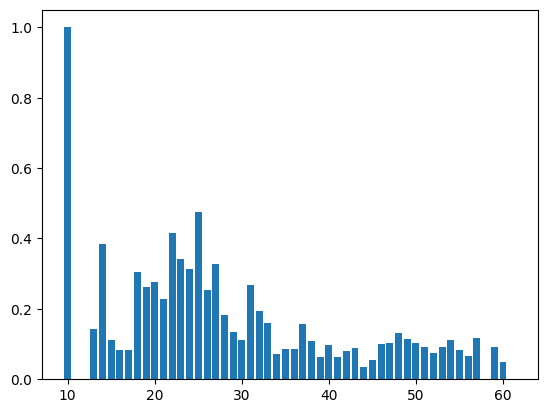

In [16]:
#年齢が若い人が成約しやすい
grouped = df2.groupby("Age")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

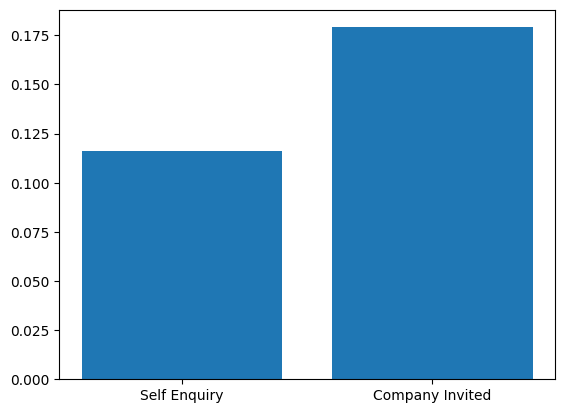

In [17]:
#　Company Invited　が成約しやすい
grouped = df2.groupby("TypeofContact")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

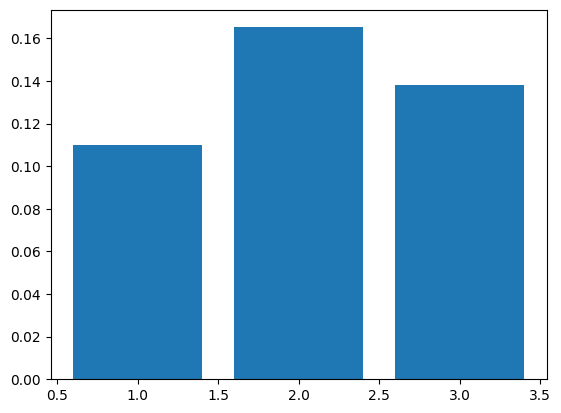

In [18]:
#　都市層　に関係は小さい
grouped = df2.groupby("CityTier")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

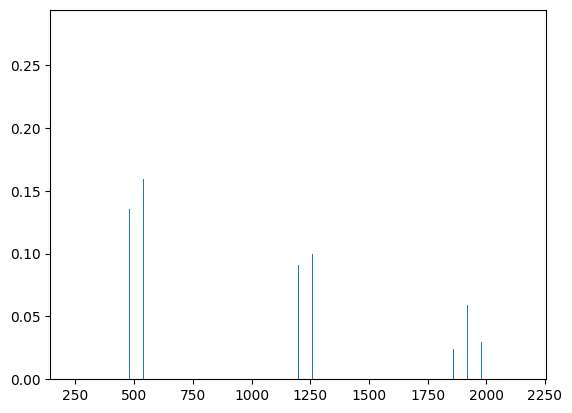

In [19]:
#　セールス時間　が短い方が成約しやすい
grouped = df2.groupby("DurationOfPitch")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

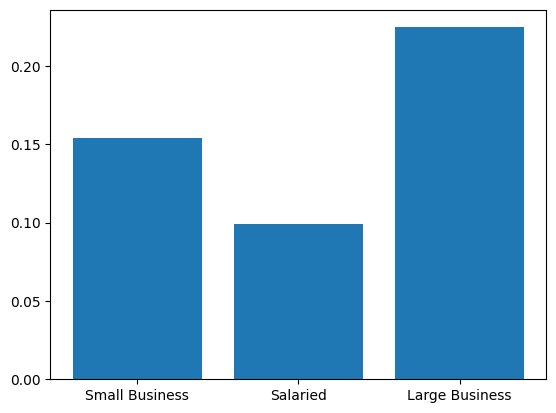

In [20]:
#　Large Business　が成約しやすい
grouped = df2.groupby("Occupation")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

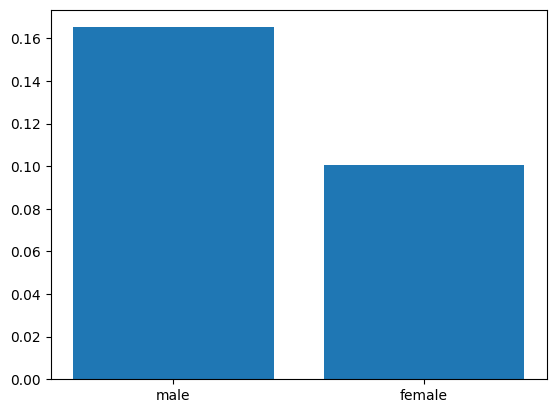

In [21]:
#　男性　が成約しやすい
grouped = df2.groupby("Gender")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

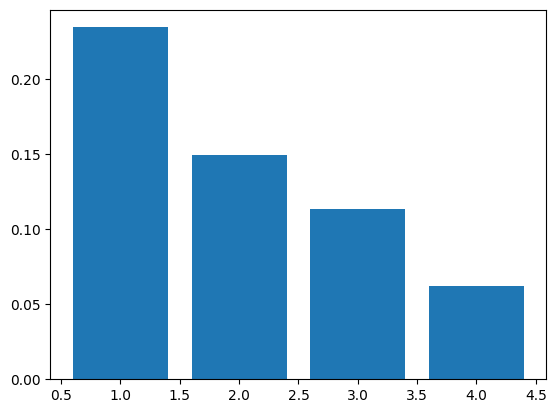

In [22]:
#　同行者の数　が少ない方が成約しやすい
grouped = df2.groupby("NumberOfPersonVisiting")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

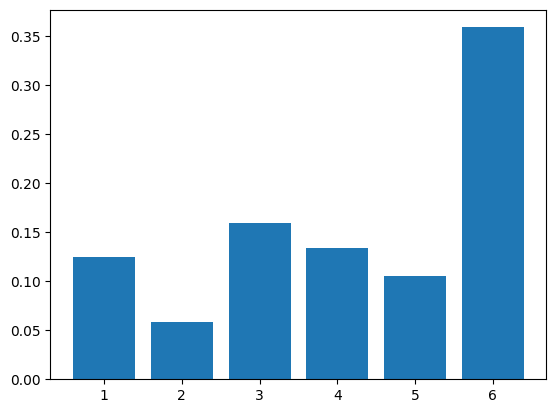

In [36]:
#　NumberOfFollowups　が6回が成約しやすい
grouped = df2.groupby("NumberOfFollowups")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

In [34]:
# 条件に基づいて値を変換する
df2['NumberOfFollowups'] = df2['NumberOfFollowups'].apply(lambda x: x / 100 if x >= 100 else x)
df2.describe()

,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,子供の数
count,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000
mean,38.072052,1.702121,860.530256,2.408609,3.689333,3.448846,3.232065,0.105739,2.483157,358238.229881,0.138802,0.997817
std,10.724203,0.669954,418.097727,0.730593,0.890682,0.598258,1.743036,0.307552,1.107708,74719.945668,0.345794,0.789752
min,10.000000,1.000000,240.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,240000.000000,0.000000,0.000000
25%,30.000000,1.000000,540.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,306277.500000,0.000000,0.000000
50%,38.000000,2.000000,780.000000,2.000000,4.000000,3.000000,3.000000,0.000000,2.000000,346515.000000,0.000000,1.000000
75%,47.000000,2.000000,960.000000,3.000000,4.000000,4.000000,5.000000,0.000000,3.000000,400000.000000,0.000000,2.000000
max,61.000000,3.000000,2160.000000,4.000000,6.000000,5.000000,8.000000,1.000000,5.000000,600000.000000,1.000000,3.000000


In [35]:
# column1のユニークな値を確認
unique_values = df2['NumberOfFollowups'].unique()
print("ユニークな値:", unique_values)

# column1の値のカウント
value_counts = df2['NumberOfFollowups'].value_counts()
print("\n値のカウント:\n", value_counts)

ユニークな値: [4. 3. 5. 1. 2. 6.]

値のカウント:
 NumberOfFollowups
4.0    1353
3.0    1147
5.0     493
2.0     102
1.0      72
6.0      39
Name: count, dtype: int64


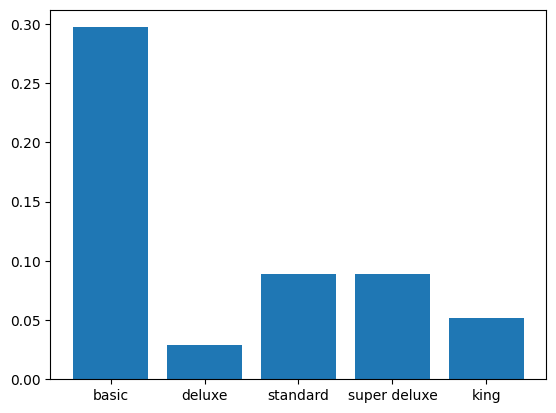

In [37]:
#　ProductPitched　が　basic　が成約しやすい
grouped = df2.groupby("ProductPitched")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

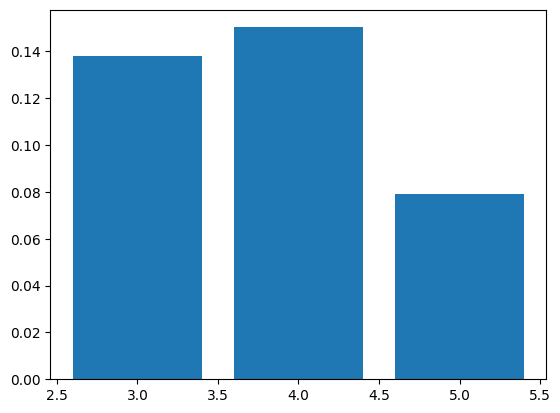

In [38]:
#　ホテルのランク　が　4　が成約しやすい
grouped = df2.groupby("PreferredPropertyStar")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

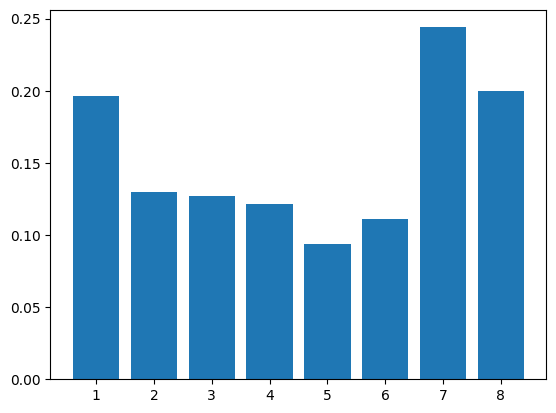

In [39]:
#　年間旅行数　が　1、7、8　が成約しやすい
grouped = df2.groupby("NumberOfTrips")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

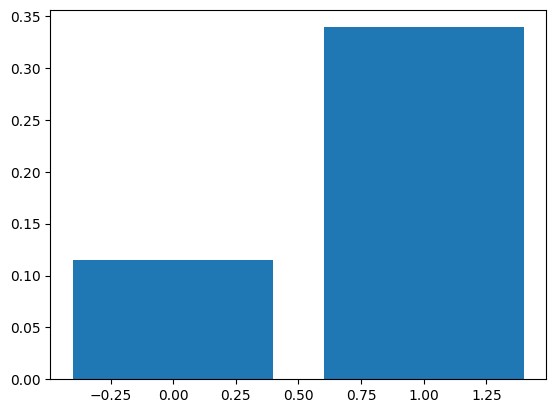

In [40]:
#　パスポート　が　所持　が成約しやすい
grouped = df2.groupby("Passport")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

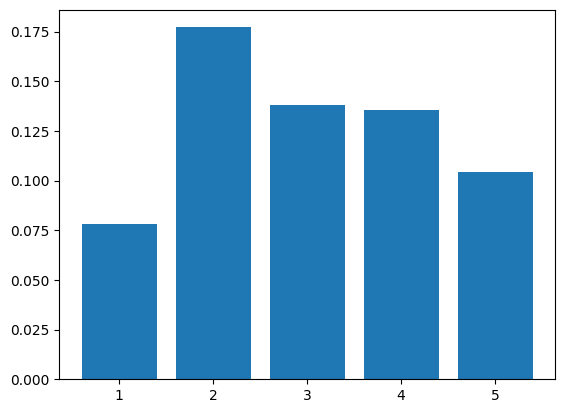

In [41]:
#　セールストーク満足度　が　2以上　が成約しやすい
grouped = df2.groupby("PitchSatisfactionScore")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

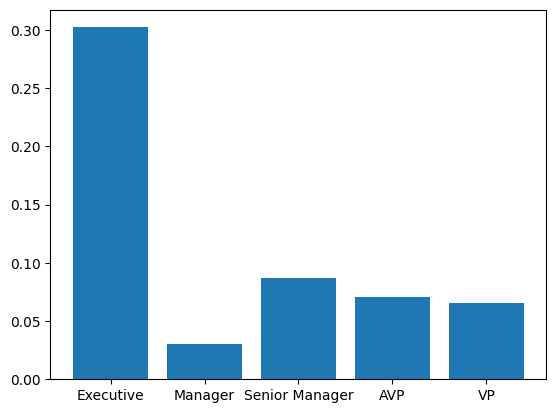

In [42]:
#　顧客の役職　が　Executive　が成約しやすい
grouped = df2.groupby("Designation")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

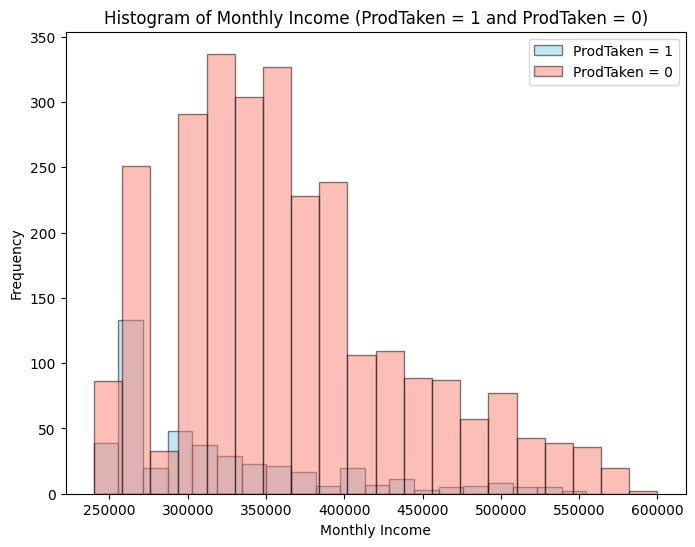

In [47]:
# 月収が　25〜30万円　が成約しやすい
import matplotlib.pyplot as plt

# ProdTakenが1の行をフィルタリング
filtered_data1 = df2[df2['ProdTaken'] == 1]
filtered_data0 = df2[df2['ProdTaken'] == 0]

# MonthlyIncomeのヒストグラムを作成
plt.figure(figsize=(8, 6))

# ProdTaken = 1のデータのヒストグラム
plt.hist(filtered_data1['MonthlyIncome'], bins=20, color='skyblue', edgecolor='black', alpha=0.5, label='ProdTaken = 1')

# ProdTaken = 0のデータのヒストグラム
plt.hist(filtered_data0['MonthlyIncome'], bins=20, color='salmon', edgecolor='black', alpha=0.5, label='ProdTaken = 0')

# グラフの詳細設定
plt.title('Histogram of Monthly Income (ProdTaken = 1 and ProdTaken = 0)')
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.legend()  # 凡例を追加

plt.show()



In [51]:
# 未婚の人が　成約しやすい
# 各 "結婚" グループごとの ProdTaken = 1 の割合を計算
percentage_taken = df2.groupby("結婚")["ProdTaken"].mean()

# 結果を表示
print(percentage_taken)


結婚
未婚      0.205699
結婚済み    0.094192
離婚済み    0.116193
Name: ProdTaken, dtype: float64


In [52]:
# 車なしの人が　成約しやすい
# 各 "車" グループごとの ProdTaken = 1 の割合を計算
percentage_taken = df2.groupby("車")["ProdTaken"].mean()

# 結果を表示
print(percentage_taken)

車
車あり    0.116883
車なし    0.153927
Name: ProdTaken, dtype: float64


In [54]:
# 子供の数が　少ない方が　成約しやすい
# 各 "車" グループごとの ProdTaken = 1 の割合を計算
percentage_taken = df2.groupby("子供の数")["ProdTaken"].mean()

# 結果を表示
print(percentage_taken)

子供の数
0    0.205788
1    0.111503
2    0.114504
3    0.071429
Name: ProdTaken, dtype: float64


In [56]:
# object を int に変換　TypeofContact、Occupation、Gender、ProductPitched、Designation、結婚、車
df2 = df.copy()

# 各 TypeofContact ごとの 成約 の割合を計算
rates1 = df.groupby('TypeofContact')['ProdTaken'].value_counts(normalize=True).unstack().fillna(0)
rates1 = rates1[1]  # 成約 のみを抽出
# 各 Occupation ごとの 成約 の割合を計算
rates2 = df2.groupby('Occupation')['ProdTaken'].value_counts(normalize=True).unstack().fillna(0)
rates2 = rates2[1]  # Charged Off のみを抽出
# 各 Gender ごとの 成約 の割合を計算
rates3 = df2.groupby('Gender')['ProdTaken'].value_counts(normalize=True).unstack().fillna(0)
rates3 = rates3[1]  # Charged Off のみを抽出
# 各 ProductPitched ごとの 成約 の割合を計算
rates4 = df2.groupby('ProductPitched')['ProdTaken'].value_counts(normalize=True).unstack().fillna(0)
rates4 = rates4[1]  # Charged Off のみを抽出
# 各 Designation ごとの 成約 の割合を計算
rates5 = df2.groupby('Designation')['ProdTaken'].value_counts(normalize=True).unstack().fillna(0)
rates5 = rates5[1]  # Charged Off のみを抽出
# 各 結婚 ごとの 成約 の割合を計算
rates6 = df2.groupby('結婚')['ProdTaken'].value_counts(normalize=True).unstack().fillna(0)
rates6 = rates6[1]  # Charged Off のみを抽出
# 各 車 ごとの 成約 の割合を計算
rates7 = df2.groupby('車')['ProdTaken'].value_counts(normalize=True).unstack().fillna(0)
rates7 = rates7[1]  # Charged Off のみを抽出

# dfのTypeofContact列をratesに基づいて数値に変換
df2['TypeofContact'] = df2['TypeofContact'].map(rates1)
df2['Occupation'] = df2['Occupation'].map(rates2)
df2['Gender'] = df2['Gender'].map(rates3)
df2['ProductPitched'] = df2['ProductPitched'].map(rates4)
df2['Designation'] = df2['Designation'].map(rates5)
df2['結婚'] = df2['結婚'].map(rates6)
df2['車'] = df2['車'].map(rates7)

df2.info()




<class 'pandas.core.frame.DataFrame'>
Index: 3206 entries, 0 to 3488
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3206 non-null   int64  
 1   TypeofContact           3206 non-null   float64
 2   CityTier                3206 non-null   int64  
 3   DurationOfPitch         3206 non-null   int64  
 4   Occupation              3206 non-null   float64
 5   Gender                  3206 non-null   float64
 6   NumberOfPersonVisiting  3206 non-null   float64
 7   NumberOfFollowups       3206 non-null   float64
 8   ProductPitched          3206 non-null   float64
 9   PreferredPropertyStar   3206 non-null   float64
 10  NumberOfTrips           3206 non-null   int64  
 11  Passport                3206 non-null   int64  
 12  PitchSatisfactionScore  3206 non-null   int64  
 13  Designation             3206 non-null   float64
 14  MonthlyIncome           3206 non-null   int64

In [57]:
df2.to_csv('df_train.csv')

In [74]:
df3 = pd.read_csv('/content/test.csv')
df3.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info
0,3489,４８歳,Self Enquiry,2,13分,Small Business,Male,1.0,4.0,Super De|uxe,3.0,7,0,3,AVP,496950.0,結婚済み 車所持 子供なし
1,3490,30代,Self Enquiry,2,12分,Small Business,Ｆｅｍａｌｅ,1.0,4.0,Standard,3.0,4,1,3,Senior Manager,月収30.0万円,結婚済み、車未所持、子供なし
2,3491,25歳,Self Enquiry,1,540秒,Salaried,Female,1.0,4.0,Basic,3.0,1,0,3,Executive,月収26.0万円,離婚済み、自動車未所有、子供なし
3,3492,21歳,Company Invited,2,420秒,Salaried,Male,1.0,4.0,Basic,4.0,1,0,3,Senior Manager,259875.0,離婚済み、自動車所有、子供なし
4,3493,41歳,Company Invited,1,7分,Salaried,MALE,1.0,4.0,Basic,3.0,1,0,4,Executive,268830.0,独身/車所持／子供なし


In [75]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3396 non-null   object 
 2   TypeofContact           3477 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3358 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3465 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3447 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [85]:
import pandas as pd

# df2の各列の最頻値（モード値）を取得
mode_values = df2.mode().iloc[0]

# 欠損値を最頻値で埋める（df3の型に合わせる）
df3['Age'] = df3['Age'].fillna(str(mode_values['Age']))  # object型として文字列で埋める
df3['TypeofContact'] = df3['TypeofContact'].fillna(str(mode_values['TypeofContact']))  # object型
df3['DurationOfPitch'] = df3['DurationOfPitch'].fillna(str(mode_values['DurationOfPitch']))  # object型
df3['NumberOfTrips'] = df3['NumberOfTrips'].fillna(str(mode_values['NumberOfTrips']))  # object型
df3['MonthlyIncome'] = df3['MonthlyIncome'].fillna(str(mode_values['MonthlyIncome']))  # object型
df3['NumberOfFollowups'] = df3['NumberOfFollowups'].fillna(float(mode_values['NumberOfFollowups']))  # float64型

# その他の列も必要であれば同様に処理できます
df4 = df3.copy()
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   object 
 2   TypeofContact           3489 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3489 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3489 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3489 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [86]:
# Age列の変換を実行
df4['Age'] = df4['Age'].apply(convert_age)

df4['Age'].describe()

,Age
count,3489.000000
mean,37.553454
std,10.655552
min,10.000000
25%,30.000000
50%,37.000000
75%,46.000000
max,61.000000


In [87]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3489 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3489 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3489 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3489 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [88]:
# DurationOfPitch列の変換を実行
df4['DurationOfPitch'] = df4['DurationOfPitch'].apply(convert_duration)
df4['DurationOfPitch'].describe()

,DurationOfPitch
count,3489.000000
mean,842.441960
std,451.417745
min,0.000000
25%,540.000000
50%,780.000000
75%,960.000000
max,2160.000000


In [89]:
# Gender列の変換を実行
df4['Gender'] = df4['Gender'].apply(convert_gender)

In [90]:
# column1のユニークな値を確認
unique_values = df4['ProductPitched'].unique()
print("ユニークな値:", unique_values)

# column1の値のカウント
value_counts = df4['ProductPitched'].value_counts()
print("\n値のカウント:\n", value_counts)

ユニークな値: ['Super De|uxe' 'Standard' 'Basic' 'Deluxe' 'Super Deluxe' 'DELUXE' 'King'
 'standard' 'basic' 'BASIC' 'basıc' 'STANDARD' 'SUPER DELUXE' 'Ѕtandard'
 'super deluxe' '𐊡asic' 'SUPER ᎠELUXE' 'SUPER ᗞELUXE' 'Βasic' 'king'
 'Basiс' 'ꓢtandard' 'Super 𝙳eluxe' 'ᗞeluxe' 'Basi𝘤' 'Staոdard' 'deluxe'
 'DELUXΕ' 'De|uxe' 'Basıc' 'Delu×e' 'basiϲ' 'Baｓic' 'Вasic' 'Stand𝖺rd'
 'KING' 'B𝖺si𝘤' 'basiс' '𝙳eluxe' 'Ꭰeluxe' 'BASIС' 'Super ᗞeluxe'
 'STANDARᎠ' 'Stan𝔡ard' 'STΑNDARD' 'ᗞELUXE' 'Baｓıc' 'de|uxe' 'Super Ꭰeluxe'
 'Super Delu×e' 'Basıϲ' 'ꓢuper Deluxe' 'SUPΕR ᎠELUXE' 'Ꭰe|uxe' 'B𝖺sic'
 'Basiϲ' 'stan𝔡ard' 'BASΙC' 'basi𝘤' 'stand𝖺rd' 'St𝖺ndard' 'Kıng' 'baｓic'
 'Bası𝘤' 'BASΙС' 'S𝘵𝖺nda𝘳d' 'kiոg' 'Standa𝘳d' 'standar𝔡' 'Stand𝖺𝘳d'
 'BAЅIC']

値のカウント:
 ProductPitched
Basic           923
Deluxe          824
Standard        591
Super Deluxe    233
King            126
               ... 
BASIС             1
𐊡asic             1
Вasic             1
basiс             1
BAЅIC             1
Name: count, Length: 71, 

In [101]:
df5 = df4.copy()

In [102]:
# 変換関数の定義
def convert_product(product_str):
    # 小文字に変換
    product_str = product_str.lower()

    # 特定の文字列の置換
    product_str = re.sub(r'de[|×]?u[|×]?xe', 'deluxe', product_str)
    product_str = re.sub(r'super\s?deluxe', 'super deluxe', product_str)

    # 統一した文字列の定義
    if 'super deluxe' in product_str or 'super dεluxe' in product_str:
        return 'super deluxe'
    elif ('ꭰeluxe' in product_str or
          'de|u×e' in product_str or
          'delu×e' in product_str or
          'ᗞeluxe' in product_str or
          'ꭰeluxe' in product_str or
          '𝙳eluxe' in product_str or
          'dεluxε' in product_str or
          'deluxe' in product_str or
          'deluxε' in product_str or
          'ꭰe|uxe' in product_str or
          'deluxε' in product_str or

        'deluxe' in product_str):
        return 'deluxe'
    elif ('standard' in product_str or
          'stanᗞard' in product_str or
          'standar𝔡' in product_str or
          'staոdard' in product_str or
          'st𝖺ndard' in product_str or
          's𝘵andard' in product_str or
          'stand𝖺rd' in product_str or
          'տtandard' in product_str or
          'standarꭰ' in product_str or
          'ꓢtandard' in product_str or
          'ѕtandard' in product_str or
          'ꓢtandard' in product_str or
          'տtanda𝘳d' in product_str or
          'ѕtandard' in product_str or
          'տtandard' in product_str or
          'տtandard' in product_str or
          'տtandard' in product_str or
          'stand𝖺𝘳d' in product_str or
          's𝘵𝖺nda𝘳d' in product_str or
          'stαndard' in product_str or
          'stan𝔡ard' in product_str or

          'standa𝘳d' in product_str):
        return 'standard'
    elif ('basic' in product_str or
          'basiс' in product_str or
          'b𝖺sic' in product_str or
          'baꓢic' in product_str or
          'βasic' in product_str or
          'вasic' in product_str or
          'basi𝘤' in product_str or
          'basiϲ' in product_str or
          'baտic' in product_str or
          'βası𝘤' in product_str or
          'baｓic' in product_str or
          '𐊡asic' in product_str or
          'basιc' in product_str or
          'в𝖺sic' in product_str or
          '𐊡asi𝘤' in product_str or
          'βasıc' in product_str or
          'b𝖺si𝘤' in product_str or
          'вasic' in product_str or
          'βasiс' in product_str or
          'βasiс' in product_str or
          'baѕic' in product_str or
          'basιс' in product_str or
          'bası𝘤' in product_str or
          'basıϲ' in product_str or
          'baｓıc' in product_str or

          'basıc' in product_str):
        return 'basic'
    elif 'king' in product_str or 'kıng' in product_str or 'kıոg' in product_str or 'kiոg' in product_str:
        return 'king'
    else:
        print(f"Unknown product: {product_str}")  # デバッグ用のログ
        return 'unknown'  # 該当しない場合は'unknown'を返す

# ProductPitched列の変換を実行
df5['ProductPitched'] = df5['ProductPitched'].apply(convert_product)

# 重複を削除し、最終的な結果を表示
unique_products = df5['ProductPitched'].unique()


In [103]:
# column1のユニークな値を確認
unique_values = df5['ProductPitched'].unique()
print("ユニークな値:", unique_values)

# column1の値のカウント
value_counts = df5['ProductPitched'].value_counts()
print("\n値のカウント:\n", value_counts)

ユニークな値: ['super deluxe' 'standard' 'basic' 'deluxe' 'king']

値のカウント:
 ProductPitched
basic           1190
deluxe          1057
standard         773
super deluxe     309
king             160
Name: count, dtype: int64


In [104]:
# column1のユニークな値を確認
unique_values = df5['NumberOfTrips'].unique()
print("ユニークな値:", unique_values)

# column1の値のカウント
value_counts = df5['NumberOfTrips'].value_counts()
print("\n値のカウント:\n", value_counts)

ユニークな値: ['7' '4' '1' '年に6回' '5' '3' '2' '年に4回' '年に1回' '6' '年に2回' '年に3回' '年に5回'
 '年に7回' '2.0' '半年に1回' '四半期に1回' '年に8回' '8']

値のカウント:
 NumberOfTrips
2         950
3         762
5         400
1         320
7         226
年に2回      153
4         136
6         125
年に3回      124
年に1回       72
年に5回       62
2.0        42
年に4回       31
年に7回       31
年に6回       26
8          12
半年に1回      10
年に8回        4
四半期に1回      3
Name: count, dtype: int64


In [105]:
# 変換ルールを定義する
def convert_trips(trip):
    if trip == '半年に1回':
        return 2
    elif trip == '四半期に1回':
        return 4
    elif trip == '2.0':
        return 2
    else:
        # 日本語を削除して整数に変換
        return int(''.join(filter(str.isdigit, trip)))

# すべてのトリップ数に変換を適用
df5['NumberOfTrips'] = df5['NumberOfTrips'].apply(convert_trips)

# 結果を確認
print(df5['NumberOfTrips'].unique())

[7 4 1 6 5 3 2 8]


In [106]:
# column1のユニークな値を確認
unique_values = df5['NumberOfTrips'].unique()
print("ユニークな値:", unique_values)

# column1の値のカウント
value_counts = df5['NumberOfTrips'].value_counts()
print("\n値のカウント:\n", value_counts)

ユニークな値: [7 4 1 6 5 3 2 8]

値のカウント:
 NumberOfTrips
2    1155
3     886
5     462
1     392
7     257
4     170
6     151
8      16
Name: count, dtype: int64


In [107]:
df6 = df5.copy()
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3489 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3489 non-null   int64  
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3489 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3489 non-null   int64  
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [108]:


# すべての役職に変換を適用
df6['Designation'] = df6['Designation'].apply(standardize_designation)

# 最後に残った 'unknown' を 'Manager' に変換
df6['Designation'] = df6['Designation'].replace('unknown', 'Manager')


# 結果を確認
print(df6['Designation'].unique())

['AVP' 'Senior Manager' 'Executive' 'Manager' 'VP']


In [109]:
# column1のユニークな値を確認
unique_values = df6['Designation'].unique()
print("ユニークな値:", unique_values)

# column1の値のカウント
value_counts = df6['Designation'].value_counts()
print("\n値のカウント:\n", value_counts)

ユニークな値: ['AVP' 'Senior Manager' 'Executive' 'Manager' 'VP']

値のカウント:
 Designation
Executive         1180
Manager           1076
Senior Manager     764
AVP                307
VP                 162
Name: count, dtype: int64


In [110]:
df8 = df6.copy()
# 変換を適用
df8['MonthlyIncome'] = df8['MonthlyIncome'].apply(convert_income)

In [111]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3489 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3489 non-null   int64  
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3489 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3489 non-null   int64  
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [112]:
df9 = df8.copy()
df9[['結婚', '車', '子供の数']] = df9['customer_info'].apply(extract_info)
df9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3489 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3489 non-null   int64  
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3489 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3489 non-null   int64  
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [113]:
df10 = df9.copy()
# dfのTypeofContact列をratesに基づいて数値に変換
df10['TypeofContact'] = df10['TypeofContact'].map(rates1)
df10['Occupation'] = df10['Occupation'].map(rates2)
df10['Gender'] = df10['Gender'].map(rates3)
df10['ProductPitched'] = df10['ProductPitched'].map(rates4)
df10['Designation'] = df10['Designation'].map(rates5)
df10['結婚'] = df10['結婚'].map(rates6)
df10['車'] = df10['車'].map(rates7)

df10.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3477 non-null   float64
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3489 non-null   int64  
 5   Occupation              3489 non-null   float64
 6   Gender                  3489 non-null   float64
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3489 non-null   float64
 9   ProductPitched          3489 non-null   float64
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3489 non-null   int64  
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [118]:
df10.to_csv('df_test.csv')

In [117]:
# column1のユニークな値を確認
unique_values = df10['NumberOfFollowups'].unique()
print("ユニークな値:", unique_values)

# column1の値のカウント
value_counts = df10['NumberOfFollowups'].value_counts()
print("\n値のカウント:\n", value_counts)

ユニークな値: [4. 3. 5. 1. 2. 6.]

値のカウント:
 NumberOfFollowups
4.0    1390
3.0    1265
5.0     598
2.0     105
1.0     100
6.0      31
Name: count, dtype: int64


In [116]:
# 条件に基づいて値を変換する
df10['NumberOfFollowups'] = df10['NumberOfFollowups'].apply(lambda x: x / 100 if x >= 100 else x)
df10.describe()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,結婚,車,子供の数
count,3489.000000,3489.000000,3477.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,5233.000000,37.553454,0.138318,1.682717,842.441960,0.139031,0.140498,2.407567,3.680424,0.140061,3.431929,3.205216,0.095156,2.500143,0.139943,355796.341359,0.138194,0.139466,1.020063
std,1007.331872,10.655552,0.030095,0.671710,451.417745,0.038821,0.031346,0.741628,0.919755,0.115502,0.599618,1.732139,0.293473,1.153904,0.117961,76864.152096,0.050139,0.018074,0.780459
min,3489.000000,10.000000,0.116098,1.000000,0.000000,0.098926,0.100686,1.000000,1.000000,0.028634,3.000000,1.000000,0.000000,1.000000,0.030702,200000.000000,0.094192,0.116883,0.000000
25%,4361.000000,30.000000,0.116098,1.000000,540.000000,0.098926,0.100686,2.000000,3.000000,0.028634,3.000000,2.000000,0.000000,2.000000,0.030702,300000.000000,0.094192,0.116883,0.000000
50%,5233.000000,37.000000,0.116098,2.000000,780.000000,0.153699,0.165172,2.000000,4.000000,0.089286,3.000000,3.000000,0.000000,2.000000,0.086595,340000.000000,0.116193,0.153927,1.000000
75%,6105.000000,46.000000,0.179066,2.000000,960.000000,0.153699,0.165172,3.000000,4.000000,0.297143,4.000000,5.000000,0.000000,3.000000,0.302392,400000.000000,0.205699,0.153927,2.000000
max,6977.000000,61.000000,0.179066,3.000000,2160.000000,0.224551,0.165172,4.000000,6.000000,0.297143,5.000000,8.000000,1.000000,5.000000,0.302392,600000.000000,0.205699,0.153927,3.000000
